In [1]:
from util import *
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.model_selection import cross_validate, LeaveOneGroupOut, cross_val_score
from sklearn.svm import LinearSVC, SVC
from sklearn.dummy import DummyClassifier
import os
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stat
from sklearn import svm, tree, neural_network
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
import pickle

/home/vm01/anaconda3/lib/python3.8/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [2]:
atlas = datasets.fetch_atlas_juelich("maxprob-thr25-2mm")

In [3]:
masks = {"premotor":"GM Premotor cortex BA6", 
         "motor": "GM Primary motor cortex BA4a",
         "v1": "GM Visual cortex V1 BA17",
         "sup_parietal": "GM Superior parietal lobule 7P",
         "inf_parietal": "GM Inferior parietal lobule PF",
         "v5": "GM Visual cortex V5"
        }

In [5]:
subject_list = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '11', '12', '13', '14', '15', '16', '17', '18', '19']
targets = ['153', '207', '45', '99']

In [5]:
svm_predictions = []
dec_tree_predictions = []
knn_predictions = []
mlp_predictions = []
mlp_scores = []
mlp_estimators = []
weights_rotate = np.zeros((18, 6, 4), dtype = object)
weights_straight = np.zeros((18, 6, 4), dtype = object)

for s, subject_id in enumerate(subject_list):
    for m, mask in enumerate(masks.keys()):
        X_straight = []
        X_rotate = []
        for run in range(1, 11):
            run_no = str(run).zfill(2)
            beta_maps_dir = f'analyses_results/sub-{subject_id}/beta_maps/trial_level/run-{run_no}/'
            run_beta_maps = os.listdir(f'analyses_results/sub-{subject_id}/beta_maps/trial_level/run-{run_no}/')

            z_maps = {}

            for i in run_beta_maps:
                if 'prep' in i:
                    z_maps[i[5:-7]] = image.load_img(os.path.join(beta_maps_dir, i))

            #Sorted by first number
            all_images = image.concat_imgs((z_maps['153'], z_maps['207'], z_maps['45'], z_maps['99']))


            mask_image = image.new_img_like(atlas.maps, image.get_data(atlas.maps) == np.where(np.array(atlas.labels) == masks[mask])[0][0])
            resampled_mask = image.resample_to_img(mask_image, all_images, interpolation='nearest')

            fmri_masked = masking.apply_mask(all_images, mask_img=resampled_mask)
            if run%2 == 0:
                X_rotate.append(fmri_masked)
            else:
                X_straight.append(fmri_masked)

                #X_test.append(fmri_masked[1::2])

                #X = np.concatenate(X)
                #X = fmri_masked
        X_rotate = np.concatenate(X_rotate)
        X_straight = np.concatenate(X_straight)                                    
            
        for t, target_loc in enumerate(['153', '207', '45', '99']):
            y = np.full((200), 'not '+target_loc)
            for run in range(5):
                y[(t+run*4)*10:(t+(run*4)+1)*10] = target_loc
                
            y_straight = y 
            y_rotate = y

            sv_rotate = neural_network.MLPClassifier(hidden_layer_sizes=(40, 20, 10))
            sv_rotate.fit(X_rotate, y_rotate)

            sv_straight = neural_network.MLPClassifier(hidden_layer_sizes=(40, 20, 10))
            sv_straight.fit(X_straight, y_straight)

            weights_rotate[s][m][t] = sv_rotate.coefs_
            weights_straight[s][m][t] = sv_straight.coefs_


        print("Mask done: ", mask)
    print('Subject done:', subject_id)

Mask done:  premotor
Mask done:  motor
Mask done:  v1
Mask done:  sup_parietal
Mask done:  inf_parietal
Mask done:  v5
Subject done: 01
Mask done:  premotor
Mask done:  motor
Mask done:  v1
Mask done:  sup_parietal
Mask done:  inf_parietal
Mask done:  v5
Subject done: 02
Mask done:  premotor
Mask done:  motor
Mask done:  v1
Mask done:  sup_parietal
Mask done:  inf_parietal


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Mask done:  v5
Subject done: 03
Mask done:  premotor
Mask done:  motor
Mask done:  v1
Mask done:  sup_parietal
Mask done:  inf_parietal


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Mask done:  v5
Subject done: 04
Mask done:  premotor
Mask done:  motor
Mask done:  v1
Mask done:  sup_parietal


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Mask done:  inf_parietal


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Mask done:  v5
Subject done: 05
Mask done:  premotor
Mask done:  motor
Mask done:  v1
Mask done:  sup_parietal
Mask done:  inf_parietal


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Mask done:  v5
Subject done: 06
Mask done:  premotor
Mask done:  motor
Mask done:  v1
Mask done:  sup_parietal
Mask done:  inf_parietal


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Mask done:  v5
Subject done: 07
Mask done:  premotor
Mask done:  motor


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Mask done:  v1
Mask done:  sup_parietal
Mask done:  inf_parietal


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Mask done:  v5
Subject done: 08
Mask done:  premotor
Mask done:  motor
Mask done:  v1
Mask done:  sup_parietal
Mask done:  inf_parietal


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Mask done:  v5
Subject done: 09
Mask done:  premotor
Mask done:  motor
Mask done:  v1
Mask done:  sup_parietal
Mask done:  inf_parietal
Mask done:  v5
Subject done: 11
Mask done:  premotor
Mask done:  motor
Mask done:  v1
Mask done:  sup_parietal
Mask done:  inf_parietal


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Mask done:  v5
Subject done: 12
Mask done:  premotor
Mask done:  motor
Mask done:  v1
Mask done:  sup_parietal
Mask done:  inf_parietal


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Mask done:  v5
Subject done: 13
Mask done:  premotor
Mask done:  motor
Mask done:  v1
Mask done:  sup_parietal
Mask done:  inf_parietal


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Mask done:  v5
Subject done: 14
Mask done:  premotor
Mask done:  motor
Mask done:  v1
Mask done:  sup_parietal
Mask done:  inf_parietal
Mask done:  v5
Subject done: 15
Mask done:  premotor
Mask done:  motor
Mask done:  v1
Mask done:  sup_parietal


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Mask done:  inf_parietal


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Mask done:  v5
Subject done: 16
Mask done:  premotor
Mask done:  motor
Mask done:  v1
Mask done:  sup_parietal
Mask done:  inf_parietal
Mask done:  v5
Subject done: 17
Mask done:  premotor
Mask done:  motor
Mask done:  v1
Mask done:  sup_parietal
Mask done:  inf_parietal


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Mask done:  v5
Subject done: 18
Mask done:  premotor
Mask done:  motor
Mask done:  v1
Mask done:  sup_parietal
Mask done:  inf_parietal


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Mask done:  v5
Subject done: 19


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [6]:
from scipy.special import rel_entr, kl_div

In [8]:
import pickle
pickle.dump(weights_rotate, open('3mlp_weights_rotate_onevsall.pickle', 'wb'))
pickle.dump(weights_straight, open('3mlp_weights_straight_onevsall.pickle', 'wb'))


In [100]:
kl_divergence = np.zeros((18, 6, 4, 4, 4))
for s, subject in enumerate(subject_list):
    for m, mask in enumerate(masks.keys()):
        for ts, target_loc_straight in enumerate(['153', '207', '45', '99']):
            for tr, target_loc_rotate  in enumerate(['153', '207', '45', '99']):
                for layer in range(4):
                    kl_divergence[s][m][ts][tr][layer] = np.ma.masked_invalid(kl_div(weights_rotate[s][m][tr][layer], weights_straight[s][m][ts][layer])).sum()

<ipython-input-100-d217e0b723c6>:7: UserWarning: Warning: converting a masked element to nan.
  kl_divergence[s][m][ts][tr][layer] = np.ma.masked_invalid(kl_div(weights_rotate[s][m][tr][layer], weights_straight[s][m][ts][layer])).sum()


In [81]:
np.tile(np.repeat(list(masks.keys()), len(targets)*4), len(subject_list)).shape

(1728,)

In [101]:
kl_divergence_df = pd.DataFrame({'Participants': np.repeat(subject_list, len(masks.keys())*len(targets)*len(targets)*4), 
                                 'Masks': np.tile(np.repeat(list(masks.keys()), len(targets)*len(targets)*4), len(subject_list)),
                                 'Target Location Straight': np.tile(np.repeat(targets, len(targets)*4), len(subject_list)*len(masks.keys())),
                                 'Target Location Rotate': np.tile(np.repeat(targets, 4), len(targets)*len(subject_list)*len(masks.keys())),                                 
                                 'Layers': np.tile(range(4), len(subject_list)*len(masks.keys())*len(targets)*len(targets)),
                                 'Kl Div': np.ravel(kl_divergence)
                                })

In [105]:
kl_divergence

array([[[[[4.88835518e+02, 1.65959504e+01, 6.14946837e+00,
           2.43878511e-01],
          [5.26500687e+02, 1.90666526e+01, 5.81058654e+00,
           1.64038421e+00],
          [5.04633072e+02, 1.92873255e+01, 6.52209598e+00,
           1.11898245e+00],
          [4.93573100e+02, 2.04344735e+01, 5.83351705e+00,
           1.74741149e+00]],

         [[4.91108721e+02, 1.81603532e+01, 5.58318191e+00,
           1.72959673e+00],
          [5.28658529e+02, 1.71018877e+01, 8.14892703e+00,
           1.64283974e-01],
          [4.97249941e+02, 1.50634344e+01, 3.49146534e+00,
           1.15413961e-02],
          [4.88955253e+02, 1.78699969e+01, 5.62341892e+00,
           2.01246569e+00]],

         [[4.94483630e+02, 1.51901528e+01, 8.01842394e+00,
           3.22467754e-01],
          [5.44154395e+02, 1.66248194e+01, 8.72263899e+00,
           1.73789932e-01],
          [5.11726714e+02, 1.53846615e+01, 3.64934811e+00,
           2.11007021e-01],
          [5.01465029e+02, 1.73457118e+

In [108]:
np.ravel(kl_divergence)[4]

526.5006870320627

In [103]:
kl_divergence_df.to_csv('kl_divergence.csv')

In [6]:
svm_predictions = []
dec_tree_predictions = []
knn_predictions = []
mlp_predictions = []
mlp_scores = []
mlp_estimators = []
weights_rotate = np.zeros((18, 6, 4), dtype = object)
weights_straight = np.zeros((18, 6, 4), dtype = object)
weight_data_corr = np.zeros((18, 6, 4, 4))
weight_data_corr_3split = np.zeros((18, 6, 4, 3, 4))
weight_weight_corr = np.zeros((18, 6, 4, 4))

for s, subject_id in enumerate(subject_list):
    for m, mask in enumerate(masks.keys()):
        X_straight = []
        X_rotate = []
        for run in range(1, 11):
            run_no = str(run).zfill(2)
            beta_maps_dir = f'analyses_results/sub-{subject_id}/beta_maps/trial_level/run-{run_no}/'
            run_beta_maps = os.listdir(f'analyses_results/sub-{subject_id}/beta_maps/trial_level/run-{run_no}/')

            z_maps = {}

            for i in run_beta_maps:
                if 'prep' in i:
                    z_maps[i[5:-7]] = image.load_img(os.path.join(beta_maps_dir, i))

            #Sorted by first number
            all_images = image.concat_imgs((z_maps['153'], z_maps['207'], z_maps['45'], z_maps['99']))


            mask_image = image.new_img_like(atlas.maps, image.get_data(atlas.maps) == np.where(np.array(atlas.labels) == masks[mask])[0][0])
            resampled_mask = image.resample_to_img(mask_image, all_images, interpolation='nearest')

            fmri_masked = masking.apply_mask(all_images, mask_img=resampled_mask)
            if run%2 == 0:
                X_rotate.append(fmri_masked)
            else:
                X_straight.append(fmri_masked)

                #X_test.append(fmri_masked[1::2])

                #X = np.concatenate(X)
                #X = fmri_masked
        X_rotate = np.concatenate(X_rotate)
        #pca_rotate = PCA(n_components=0.95)
        #X_rotate_reduced = pca_rotate.fit_transform(X_rotate)
        X_straight = np.concatenate(X_straight) 
        #pca_straight = PCA(n_components=pca_rotate.components_.shape[0])
        #X_straight_reduced = pca_straight.fit_transform(X_straight)
        y_rotate = np.tile(np.repeat(['153', '207', '45', '99'], 10), 5)
        y_straight = np.tile(np.repeat(['153', '207', '45', '99'], 10), 5)
            
        lin_clf_rotate = svm.LinearSVC(max_iter=10000)
        lin_clf_rotate.fit(X_rotate, y_rotate)
        
        lin_clf_straight = svm.LinearSVC(max_iter=10000)
        lin_clf_straight.fit(X_straight, y_straight)
        
        for ts in range(len(targets)):
            weights_straight[s][m][ts] = lin_clf_straight.coef_[ts]            
            for tr, target in enumerate(targets):
                weights_rotate[s][m][tr] = lin_clf_rotate.coef_[tr]
#                 for split in range(3):
                weight_data_corr[s][m][ts][tr] = stat.pearsonr(weights_rotate[s][m][ts], np.mean(X_straight[y_straight == target], axis = 0))[0]
                #weight_weight_corr[s][m][ts][tr] = stat.pearsonr(weights_straight[s][m][ts], weights_rotate[s][m][tr])[0]                        
        
        
        print("Mask done: ", mask)
    print('Subject done:', subject_id)

Mask done:  premotor
Mask done:  motor
Mask done:  v1
Mask done:  sup_parietal
Mask done:  inf_parietal
Mask done:  v5
Subject done: 01
Mask done:  premotor
Mask done:  motor
Mask done:  v1
Mask done:  sup_parietal
Mask done:  inf_parietal
Mask done:  v5
Subject done: 02
Mask done:  premotor
Mask done:  motor
Mask done:  v1
Mask done:  sup_parietal
Mask done:  inf_parietal
Mask done:  v5
Subject done: 03
Mask done:  premotor
Mask done:  motor
Mask done:  v1
Mask done:  sup_parietal
Mask done:  inf_parietal
Mask done:  v5
Subject done: 04
Mask done:  premotor
Mask done:  motor
Mask done:  v1
Mask done:  sup_parietal
Mask done:  inf_parietal
Mask done:  v5
Subject done: 05
Mask done:  premotor
Mask done:  motor
Mask done:  v1
Mask done:  sup_parietal
Mask done:  inf_parietal
Mask done:  v5
Subject done: 06
Mask done:  premotor
Mask done:  motor
Mask done:  v1
Mask done:  sup_parietal
Mask done:  inf_parietal
Mask done:  v5
Subject done: 07
Mask done:  premotor
Mask done:  motor
Mask done

In [12]:
kl_divergence = np.zeros((18, 6, 4, 4))
for s, subject in enumerate(subject_list):
    for m, mask in enumerate(masks.keys()):
        for ts, target_loc_straight in enumerate(['153', '207', '45', '99']):
            for tr, target_loc_rotate  in enumerate(['153', '207', '45', '99']):
                kl_divergence[s][m][ts][tr] = np.ma.masked_invalid(kl_div(weights_rotate[s][m][tr], weights_straight[s][m][ts])).sum()

In [7]:
weight_data_rot_corr_df = pd.DataFrame({'Participants': np.repeat(subject_list, len(masks.keys())*len(targets)*len(targets)), 
                                 'Masks': np.tile(np.repeat(list(masks.keys()), len(targets)*len(targets)), len(subject_list)),
                                 'Target Location Straight': np.tile(np.repeat(targets, len(targets)), len(subject_list)*len(masks.keys())),
                                 'Target Location Rotate': np.tile(targets, len(targets)*len(subject_list)*len(masks.keys())),                                 
                                 'Correlation': np.ravel(weight_data_corr)
                                })
weight_data_rot_corr_df.to_csv('weight_data_rot_corr_svm_prep.csv')

In [12]:
weight_data_rot_corr_df = pd.read_csv('weight_data_rot_corr_svm_mov.csv').drop('Unnamed: 0', axis = 1)

In [13]:
weight_data_rot_corr_df['aim direction'] = weight_data_rot_corr_df['Target Location Rotate'].astype(int) - 90
weight_data_rot_corr_df['aim difference'] = weight_data_rot_corr_df['aim direction'] - weight_data_rot_corr_df['Target Location Straight'].astype(int)



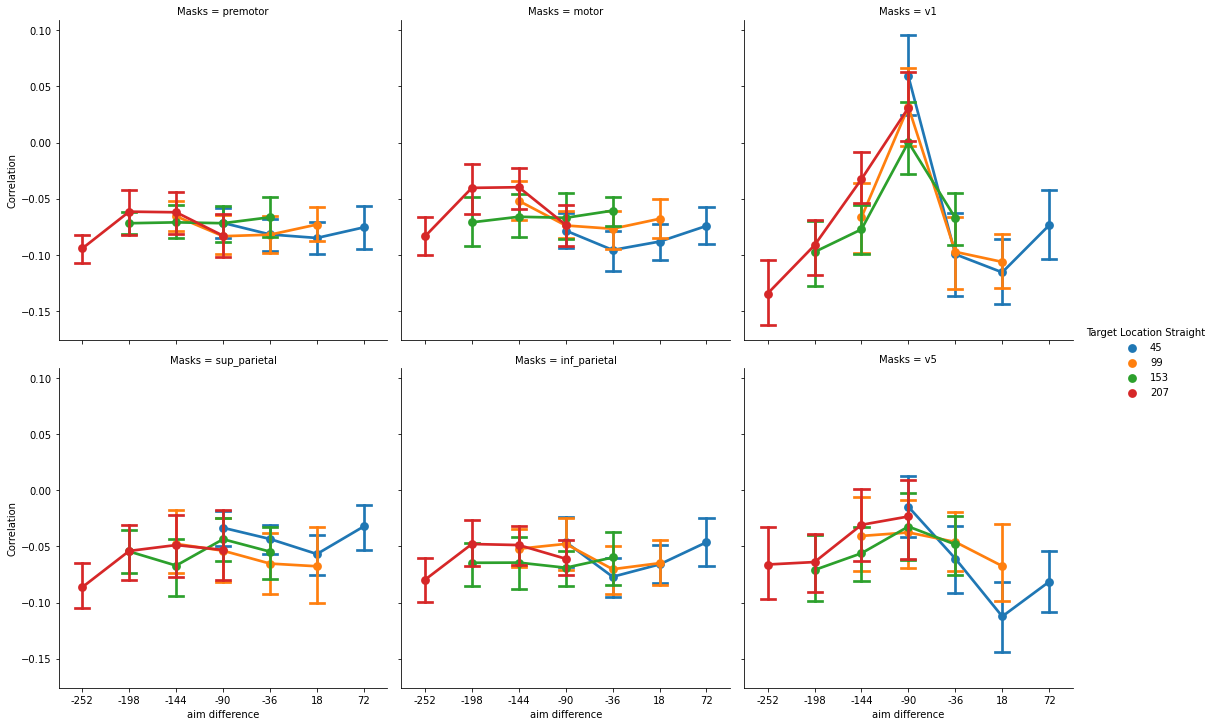

In [14]:
sns.catplot(hue = 'Target Location Straight', y = 'Correlation', x = 'aim difference', col = 'Masks',
           data = weight_data_rot_corr_df, 
           kind = 'point', col_wrap = 3, capsize = 0.3)

In [33]:
from sklearn.metrics import pairwise_distances
rdm_corr = np.zeros((18, 6, 4, 4))

for s, subject in enumerate(subject_list):
    for m, mask in enumerate(masks.keys()):
        for ts, target_loc_straight in enumerate(['153', '207', '45', '99']):
            rdm_straight = pairwise_distances(weights_straight[s][m][ts].reshape(-1, 1))
            for tr, target_loc_rotate  in enumerate(['153', '207', '45', '99']):
                rdm_rotate = pairwise_distances(weights_rotate[s][m][tr].reshape(-1, 1))
                rdm_corr[s][m][ts][tr] = stat.pearsonr(np.ravel(rdm_straight), np.ravel(rdm_rotate))[0]              


In [35]:
rdm_corr_df = pd.DataFrame({'Participants': np.repeat(subject_list, len(masks.keys())*len(targets)*len(targets)), 
                                 'Masks': np.tile(np.repeat(list(masks.keys()), len(targets)*len(targets)), len(subject_list)),
                                 'Target Location Straight': np.tile(np.repeat(targets, len(targets)), len(subject_list)*len(masks.keys())),
                                 'Target Location Rotate': np.tile(targets, len(targets)*len(subject_list)*len(masks.keys())),                                 
                                 'RDM Correlations': np.ravel(rdm_corr)
                                })
rdm_corr_df.to_csv('rdm_corr_svm.csv')

(0.046258049681444716, 0.0009560596827893046)

In [9]:
within_knn_predictions_df = pd.DataFrame({'153_prob': knn_predictions[:, 0], 
                               '207_prob': knn_predictions[:, 1],
                               '45_prob': knn_predictions[:, 2],
                               '99_prob': knn_predictions[:, 3],
                               'ROIs': np.tile(np.repeat(list(masks.keys()), 10*20), len(subject_list)),
                               'run': np.tile(np.tile(np.repeat(np.arange(1, 11), 20), len(masks.keys())), len(subject_list)), 
                               'dir_x_rest': np.tile(np.tile(np.repeat([153, 207, 45, 99], 5), 10*len(masks.keys())), len(subject_list)),
                               'block_type': np.tile(np.tile(np.repeat(['Straight', 'Rotate'], 20), 5 * len(masks.keys())), len(subject_list)),
                               'Subject_id': np.repeat(subject_list, 20*10*len(masks.keys()))
                              })

In [10]:
within_dec_tree_predictions_df = pd.DataFrame({'153_prob': dec_tree_predictions[:, 0], 
                               '207_prob': dec_tree_predictions[:, 1],
                               '45_prob': dec_tree_predictions[:, 2],
                               '99_prob': dec_tree_predictions[:, 3],
                               'ROIs': np.tile(np.repeat(list(masks.keys()), 10*20), len(subject_list)),
                               'run': np.tile(np.tile(np.repeat(np.arange(1, 11), 20), len(masks.keys())), len(subject_list)), 
                               'dir_x_rest': np.tile(np.tile(np.repeat([153, 207, 45, 99], 5), 10* len(masks.keys())), len(subject_list)),
                               'block_type': np.tile(np.tile(np.repeat(['Straight', 'Rotate'], 20), 5 * len(masks.keys())), len(subject_list)),
                               'Subject_id': np.repeat(subject_list, 20*10*len(masks.keys()))
                              })

In [11]:
within_svm_predictions_df = pd.DataFrame({'153_prob': svm_predictions[:, 0], 
                               '207_prob': svm_predictions[:, 1],
                               '45_prob': svm_predictions[:, 2],
                               '99_prob': svm_predictions[:, 3],
                               'ROIs': np.tile(np.repeat(list(masks.keys()), 10*20), len(subject_list)),
                               'run': np.tile(np.tile(np.repeat(np.arange(1, 11), 20), len(masks.keys())), len(subject_list)), 
                               'dir_x_rest': np.tile(np.tile(np.repeat([153, 207, 45, 99], 5), 10* len(masks.keys())), len(subject_list)),
                               'block_type': np.tile(np.tile(np.repeat(['Straight', 'Rotate'], 20), 5 * len(masks.keys())), len(subject_list)),
                               'Subject_id': np.repeat(subject_list, 20*10*len(masks.keys()))
                              })

In [12]:
within_predictions_df = pd.read_csv('all_way_within_pred.csv').drop('Unnamed: 0', axis = 1)
within_predictions_df_melt = within_predictions_df.melt(id_vars=['Subject_id', 'dir_x_rest', 'ROIs', 'run', 'block_type'], var_name='dirs', value_name='probs')


In [13]:
within_knn_predictions_df_melt = within_knn_predictions_df.melt(id_vars=['Subject_id', 'dir_x_rest', 'ROIs', 'run', 'block_type'], var_name='dirs', value_name='probs')
within_dec_tree_predictions_df_melt = within_dec_tree_predictions_df.melt(id_vars=['Subject_id', 'dir_x_rest', 'ROIs', 'run', 'block_type'], var_name='dirs', value_name='probs')
within_svm_predictions_df_melt = within_svm_predictions_df.melt(id_vars=['Subject_id', 'dir_x_rest', 'ROIs', 'run', 'block_type'], var_name='dirs', value_name='probs')


In [27]:
within_svm_predictions_df.to_csv('svm_within_mov_pred.csv')

In [33]:
within_knn_predictions_df.to_csv('knn_within_mov_pred.csv')

In [29]:
within_dec_tree_predictions_df.to_csv('dec_tree_mov_within_pred.csv')

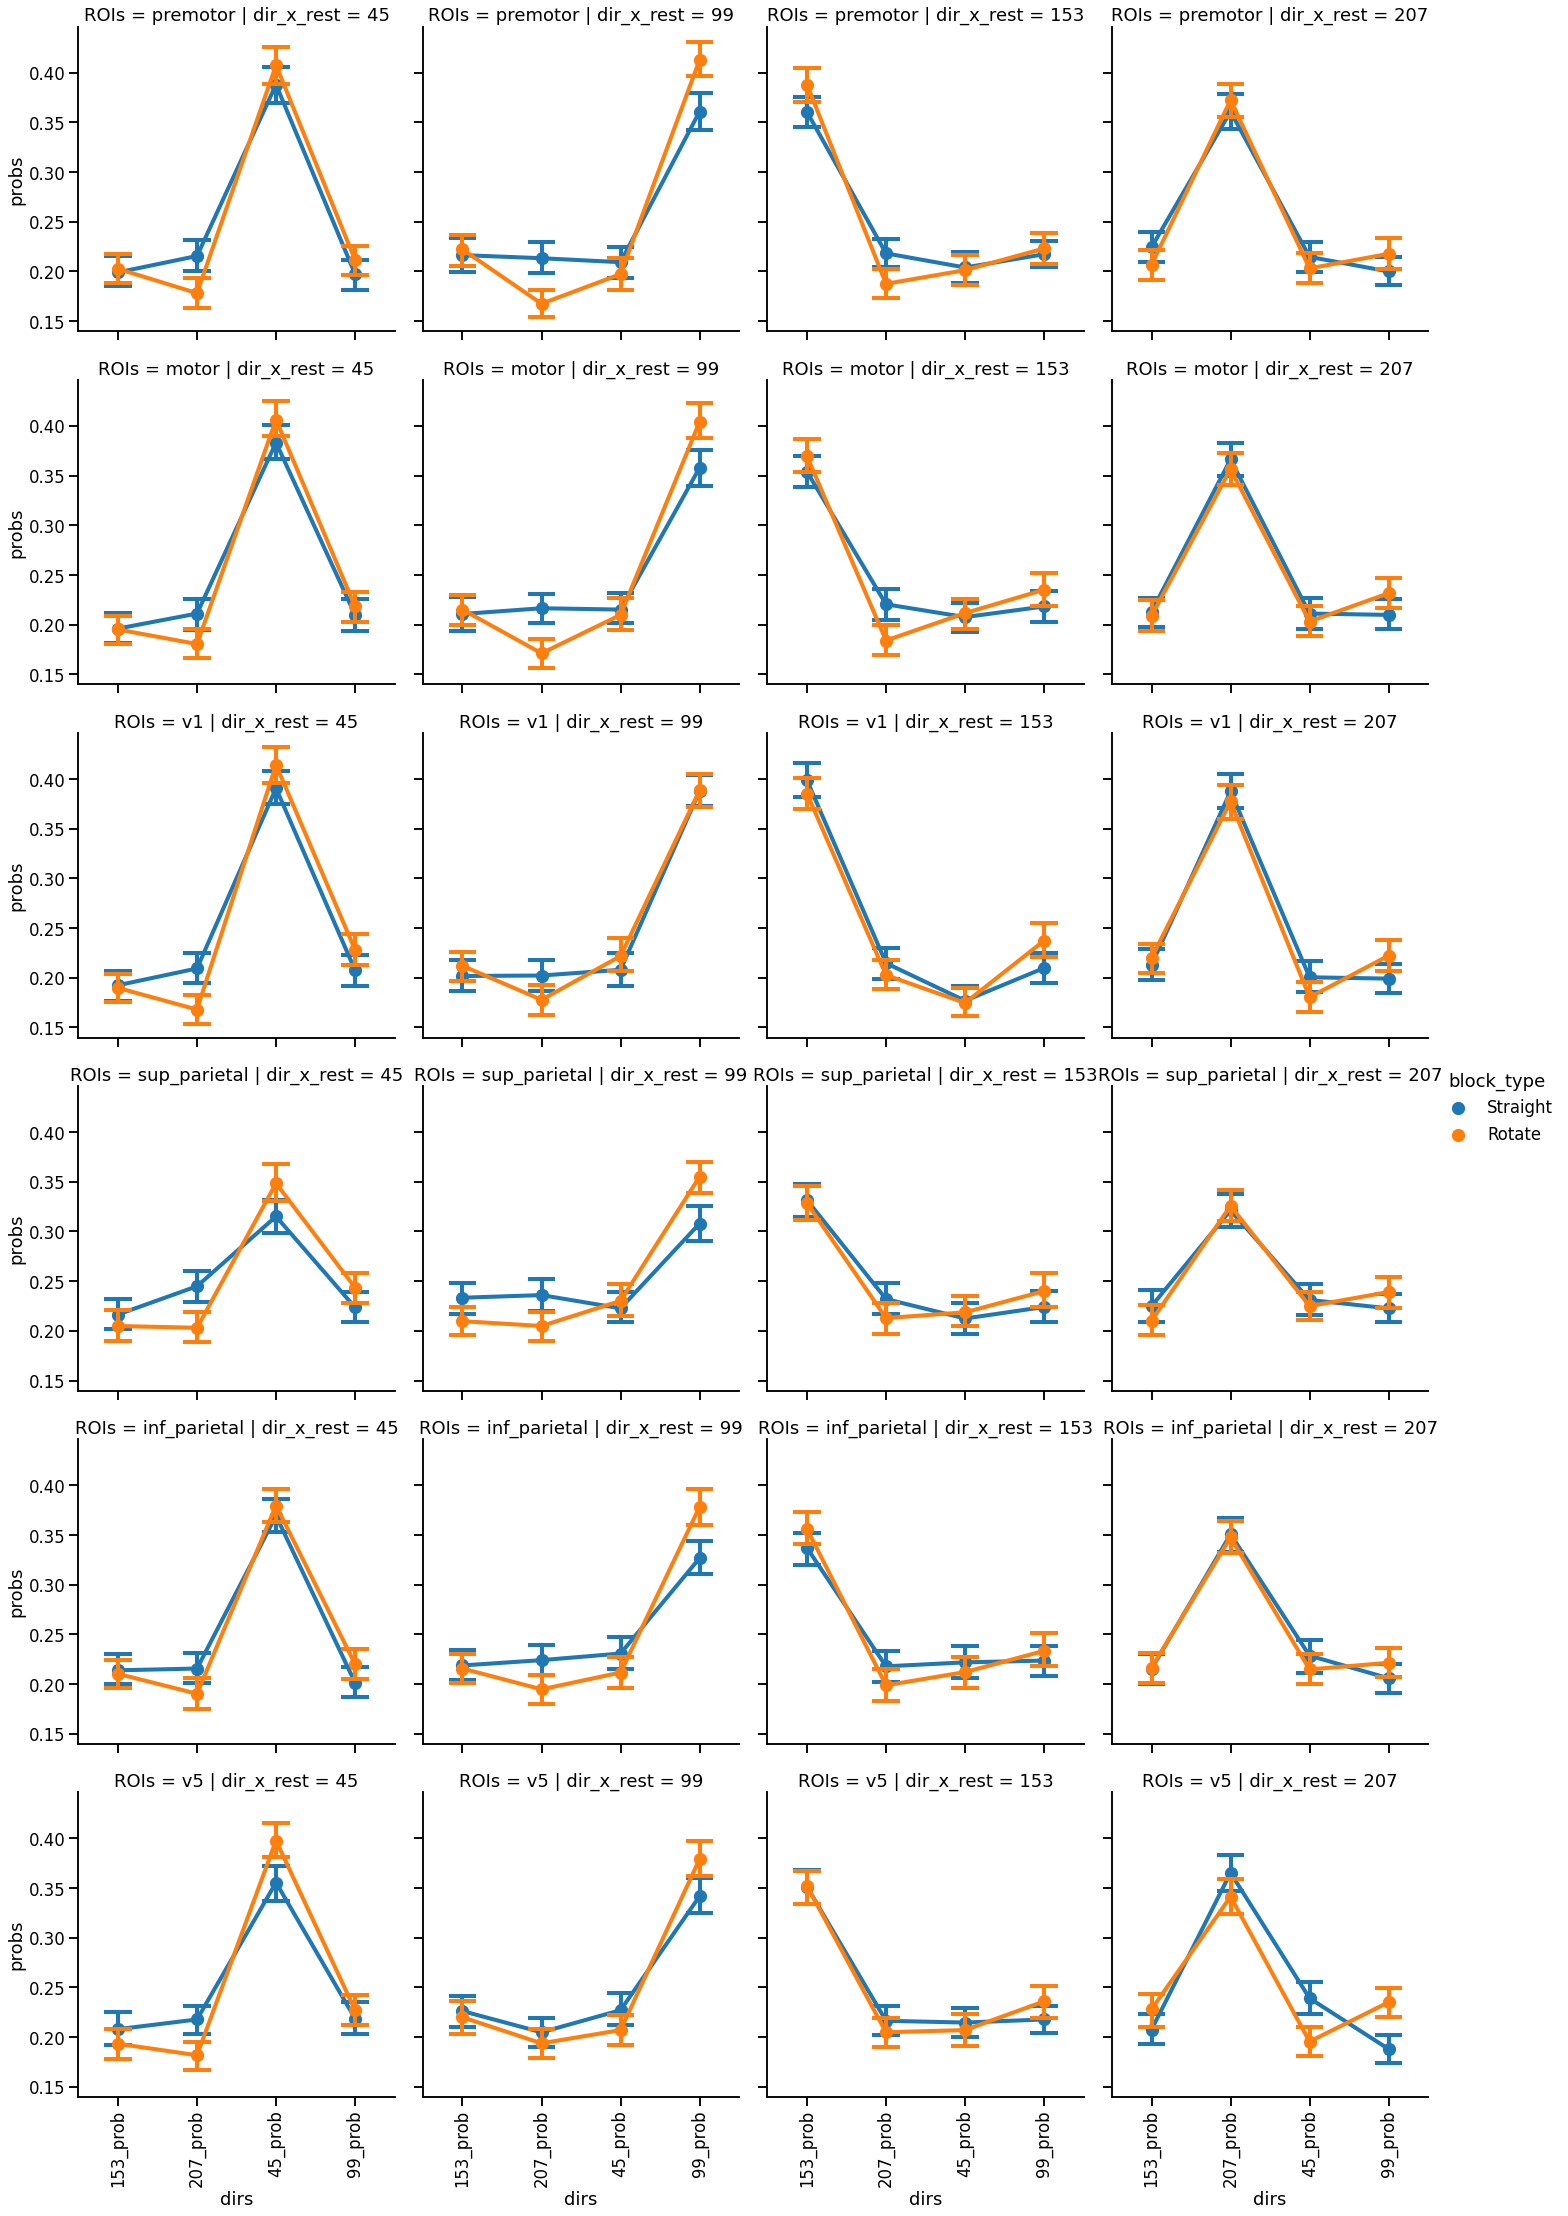

In [14]:
sns.set_context('talk')
ax = sns.catplot(x = 'dirs', y = 'probs', col = 'dir_x_rest', 
            hue = 'block_type', row = 'ROIs', 
            data = within_knn_predictions_df_melt, kind = 'point', capsize = 0.3)
ax.set_axis_labels().set_xticklabels(rotation = 90)


In [38]:
svm_predictions = []
knn_predictions = []
dec_tree_predictions = []
nn_predictions = []
for subject_id in subject_list:
    for mask in masks.keys():
        X = []
        X_test = []
        for run in range(1, 11):
            #X = []
            run_no = str(run).zfill(2)
            beta_maps_dir = f'analyses_results/sub-{subject_id}/beta_maps/trial_level/run-{run_no}/'
            run_beta_maps = os.listdir(f'analyses_results/sub-{subject_id}/beta_maps/trial_level/run-{run_no}/')

            z_maps = {}

            for i in run_beta_maps:
                if 'move' in i:
                    z_maps[i[5:-7]] = image.load_img(os.path.join(beta_maps_dir, i))

            #Sorted by first number
            all_images = image.concat_imgs((z_maps['153'], z_maps['207'], z_maps['45'], z_maps['99']))
            #mean_image = image.mean_img(all_images)
            #mean_centered = image.math_img("np.subtract(all_images, mean_image[:, :, :, None])", all_images = all_images, mean_image = mean_image)
            #mean_centered = all_images

            #for i, key in enumerate(np.sort(list(z_maps.keys()))):

                #z_maps[key] = image.index_img(mean_centered, slice(i*10,i*10+10))

            mask_image = image.new_img_like(atlas.maps, image.get_data(atlas.maps) == np.where(np.array(atlas.labels) == masks[mask])[0][0])
            resampled_mask = image.resample_to_img(mask_image, all_images, interpolation='nearest')

            fmri_masked = masking.apply_mask(all_images, mask_img=resampled_mask)
            #X.append(fmri_masked)
            #X_test.append(fmri_masked[1::2])

            #X = np.concatenate(X)
            if run%2 != 0:
                X.append(fmri_masked)
                #y = np.repeat(['153', '207', '45', '99'], 10)
                #clf_svm = OneVsRestClassifier(svm.SVC(probability = True))                
                #clf_svm.fit(X, y)
                #clf_knn = OneVsRestClassifier(KNeighborsClassifier())                
                #clf_knn.fit(X, y)
                #clf_dec_tree = OneVsRestClassifier(tree.DecisionTreeClassifier())                
                #clf_dec_tree.fit(X, y)
                
                
            else:
                X_test.append(fmri_masked)
                #y_test = np.repeat(['153', '207', '45', '99'], 10)
                
                #svm_predictions.append(clf_svm.predict_proba(X_test))
                #knn_predictions.append(clf_knn.predict_proba(X_test))
                #dec_tree_predictions.append(clf_dec_tree.predict_proba(X_test))
                
                
        X = np.concatenate(X)
        X_test = np.concatenate(X_test)
        y = np.tile(np.repeat(['153', '207', '45', '99'], 5), 5)
        #y_test = np.tile(np.repeat(['153', '207', '45', '99'], 10), 5)
            
        clf = OneVsRestClassifier(svm.SVC(probability = True))
        clf.fit(X, y)
        svm_predictions.append(clf.predict_proba(X_test))
        
        clfk = OneVsRestClassifier(KNeighborsClassifier())
        clfk.fit(X, y)
        knn_predictions.append(clfk.predict_proba(X_test))
        
        clft = OneVsRestClassifier(tree.DecisionTreeClassifier())
        clft.fit(X, y)
        dec_tree_predictions.append(clft.predict_proba(X_test))
        
        clfnn = neural_network.MLPClassifier(learning_rate='adaptive')
        clfnn.fit(X, y)
        #clfnn_predictions.append(clfnn.predict_proba(X_test))
        
        print("Mask done: ", mask)
    print('Subject done:', subject_id)



/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  premotor


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  motor


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  v1


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  sup_parietal


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  inf_parietal


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  v5
Subject done: 01


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  premotor


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  motor


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  v1


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  sup_parietal


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  inf_parietal


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  v5
Subject done: 02


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  premotor


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  motor


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  v1


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  sup_parietal


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  inf_parietal


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  v5
Subject done: 03


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  premotor


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  motor


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  v1


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  sup_parietal


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  inf_parietal


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  v5
Subject done: 04


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  premotor


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  motor


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  v1


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  sup_parietal


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  inf_parietal


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  v5
Subject done: 05


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  premotor


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  motor


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  v1


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  sup_parietal


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  inf_parietal


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  v5
Subject done: 06


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  premotor


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  motor


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  v1


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  sup_parietal


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  inf_parietal


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  v5
Subject done: 07


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  premotor


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  motor


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  v1


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  sup_parietal


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  inf_parietal


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  v5
Subject done: 08


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  premotor


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  motor


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  v1


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  sup_parietal


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  inf_parietal


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  v5
Subject done: 09


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  premotor


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  motor


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  v1


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  sup_parietal


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  inf_parietal


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  v5
Subject done: 11


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  premotor


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  motor


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  v1


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  sup_parietal


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  inf_parietal


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  v5
Subject done: 12


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  premotor


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  motor


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  v1


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  sup_parietal


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  inf_parietal


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  v5
Subject done: 13


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  premotor


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  motor


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  v1


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  sup_parietal


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  inf_parietal


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  v5
Subject done: 14


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  premotor


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  motor


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  v1


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  sup_parietal


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  inf_parietal


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  v5
Subject done: 15


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  premotor


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  motor


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  v1


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  sup_parietal


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  inf_parietal


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  v5
Subject done: 16


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  premotor


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  motor


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  v1


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  sup_parietal


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  inf_parietal


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  v5
Subject done: 17


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  premotor


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  motor


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  v1


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  sup_parietal


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  inf_parietal


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  v5
Subject done: 18


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  premotor


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  motor


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  v1


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  sup_parietal


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  inf_parietal
Mask done:  v5
Subject done: 19


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


In [39]:
svm_predictions = np.concatenate(svm_predictions)
knn_predictions = np.concatenate(knn_predictions)
dec_tree_predictions = np.concatenate(dec_tree_predictions)
#Temp


In [40]:
#clfnn_predictions = np.concatenate(clfnn_predictions)

In [41]:
between_svm_predictions_df = pd.DataFrame({'153_prob': svm_predictions[:, 0], 
                               '207_prob': svm_predictions[:, 1],
                               '45_prob': svm_predictions[:, 2],
                               '99_prob': svm_predictions[:, 3],
                               'ROIs': np.tile(np.repeat(list(masks.keys()), 5*20), len(subject_list)),
                               'run_pairs': np.tile(np.tile(np.repeat(np.arange(1, 6), 20), len(masks.keys())), len(subject_list)), 
                               'rotate_dir': np.tile(np.tile(np.repeat([153, 207, 45, 99], 5), 5* len(masks.keys())), len(subject_list)),
                               #'block_type': np.tile(np.tile(np.repeat(['Straight', 'Rotate'], 40), 5 * len(masks.keys())), len(subject_list)),
                               'Subject_id': np.repeat(subject_list, 20*5*len(masks.keys())),
                              'dir_x_rest': np.tile(np.tile(np.repeat([153, 207, 45, 99], 5), 5* len(masks.keys())), len(subject_list)),

                              })

In [42]:
between_knn_predictions_df = pd.DataFrame({'153_prob': knn_predictions[:, 0], 
                               '207_prob': knn_predictions[:, 1],
                               '45_prob': knn_predictions[:, 2],
                               '99_prob': knn_predictions[:, 3],
                               'ROIs': np.tile(np.repeat(list(masks.keys()), 5*20), len(subject_list)),
                               'run_pairs': np.tile(np.tile(np.repeat(np.arange(1, 6), 20), len(masks.keys())), len(subject_list)), 
                               'rotate_dir': np.tile(np.tile(np.repeat([153, 207, 45, 99], 5), 5* len(masks.keys())), len(subject_list)),
                               #'block_type': np.tile(np.tile(np.repeat(['Straight', 'Rotate'], 40), 5 * len(masks.keys())), len(subject_list)),
                               'Subject_id': np.repeat(subject_list, 20*5*len(masks.keys())),
                              'dir_x_rest': np.tile(np.tile(np.repeat([153, 207, 45, 99], 5), 5* len(masks.keys())), len(subject_list)),

                              })

In [43]:
between_dec_tree_predictions_df = pd.DataFrame({'153_prob': dec_tree_predictions[:, 0], 
                               '207_prob': dec_tree_predictions[:, 1],
                               '45_prob': dec_tree_predictions[:, 2],
                               '99_prob': dec_tree_predictions[:, 3],
                               'ROIs': np.tile(np.repeat(list(masks.keys()), 5*20), len(subject_list)),
                               'run_pairs': np.tile(np.tile(np.repeat(np.arange(1, 6), 20), len(masks.keys())), len(subject_list)), 
                               'rotate_dir': np.tile(np.tile(np.repeat([153, 207, 45, 99], 5), 5* len(masks.keys())), len(subject_list)),
                               #'block_type': np.tile(np.tile(np.repeat(['Straight', 'Rotate'], 40), 5 * len(masks.keys())), len(subject_list)),
                               'Subject_id': np.repeat(subject_list, 20*5*len(masks.keys())),
                              'dir_x_rest': np.tile(np.tile(np.repeat([153, 207, 45, 99], 5), 5* len(masks.keys())), len(subject_list)),

                              })

In [44]:
between_svm_predictions_df_melt = between_svm_predictions_df.melt(id_vars=['dir_x_rest', 'Subject_id', 'rotate_dir', 'ROIs', 'run_pairs'], var_name='dirs', value_name='probs')
between_knn_predictions_df_melt = between_knn_predictions_df.melt(id_vars=['dir_x_rest', 'Subject_id', 'rotate_dir', 'ROIs', 'run_pairs'], var_name='dirs', value_name='probs')
between_dec_tree_predictions_df_melt = between_dec_tree_predictions_df.melt(id_vars=['dir_x_rest', 'Subject_id', 'rotate_dir', 'ROIs', 'run_pairs'], var_name='dirs', value_name='probs')
#between_clfnn_predictions_df_melt = between_clfnn_predictions_df.melt(id_vars=['dir_x_rest', 'Subject_id', 'rotate_dir', 'ROIs', 'run_pairs'], var_name='dirs', value_name='probs')


In [45]:
between_svm_predictions_df.to_csv('svm_between_mov_pred.csv')
between_knn_predictions_df.to_csv('knn_between_mov_pred.csv')
between_dec_tree_predictions_df.to_csv('dec_tree_between_mov_pred.csv')
#between_clfnn_predictions_df.to_csv('all_way_dec_tree_between_pred.csv')


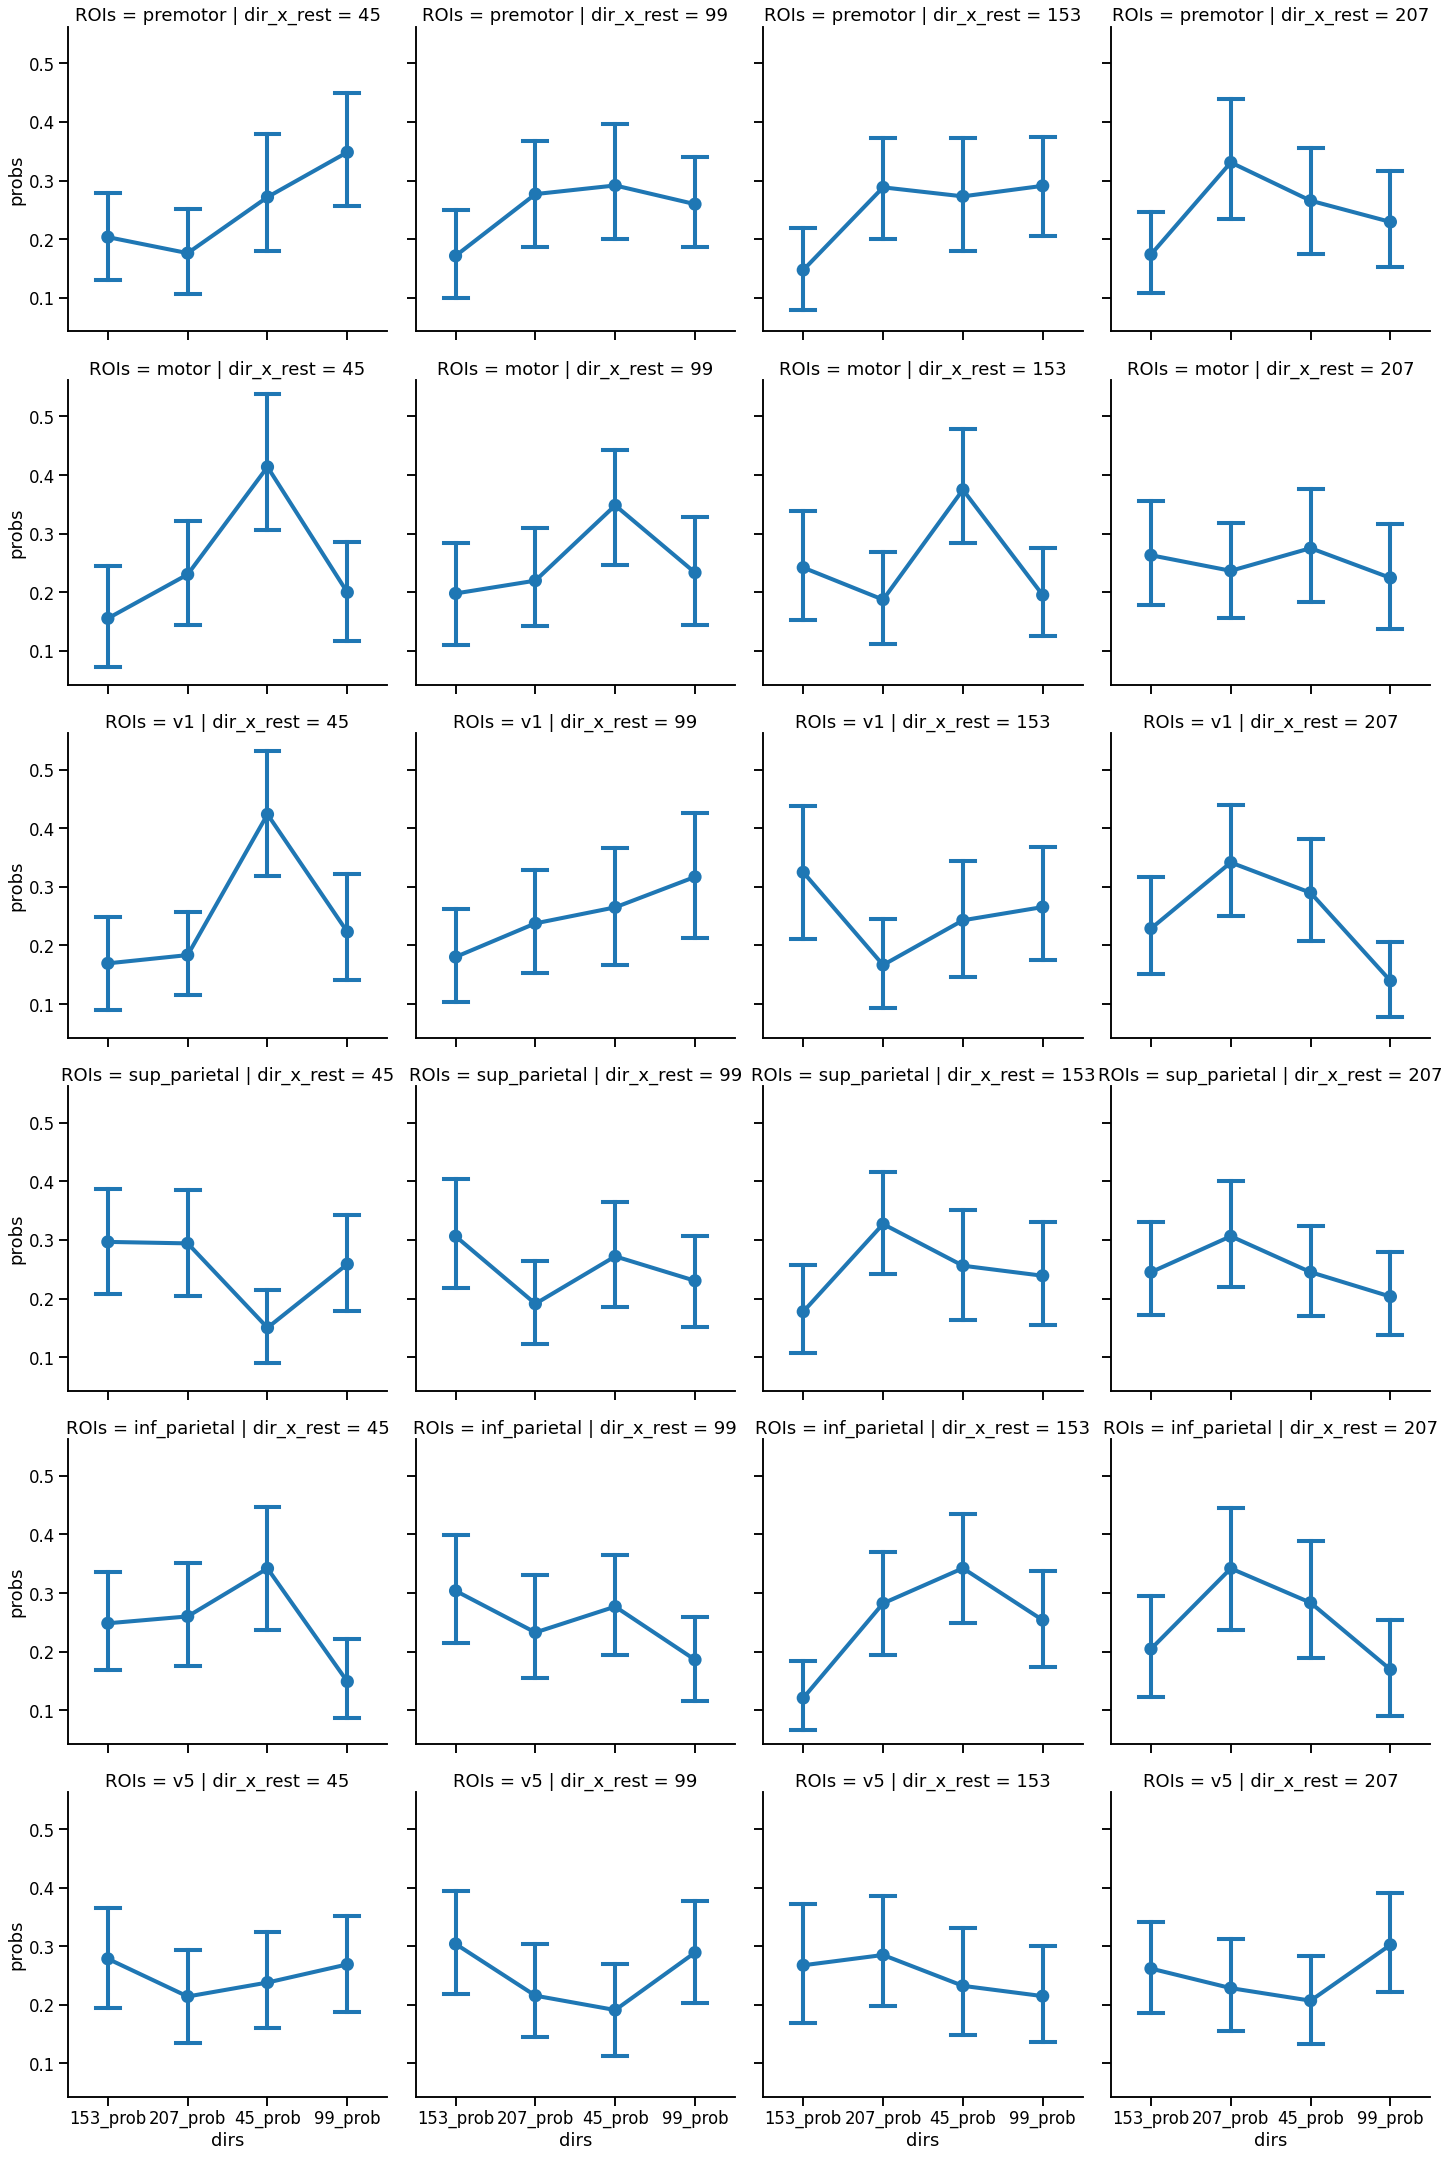

In [47]:

sns.set_context('talk')
ax = sns.catplot(x = 'dirs', y = 'probs', 
            col = 'dir_x_rest', row = 'ROIs',
            data = between_dec_tree_predictions_df_melt[between_dec_tree_predictions_df_melt.run_pairs == 1], kind = 'point', capsize = 0.3)
#ax.set_axcd is_labels().set_xticklabels(rotation = 90)


In [22]:
svm_predictions = []
knn_predictions = []
dec_tree_predictions = []
mlp_coefs = []
mlp_4h_coefs = []
#clfnn_predictions = []
for subject_id in subject_list:
    for mask in masks.keys():
        X = []
        X_test = []
        for run in range(1, 11):
            #X = []
            run_no = str(run).zfill(2)
            beta_maps_dir = f'analyses_results/sub-{subject_id}/beta_maps/trial_level/run-{run_no}/'
            run_beta_maps = os.listdir(f'analyses_results/sub-{subject_id}/beta_maps/trial_level/run-{run_no}/')

            z_maps = {}

            for i in run_beta_maps:
                if 'prep' in i:
                    z_maps[i[5:-7]] = image.load_img(os.path.join(beta_maps_dir, i))

            #Sorted by first number
            all_images = image.concat_imgs((z_maps['153'], z_maps['207'], z_maps['45'], z_maps['99']))

            mask_image = image.new_img_like(atlas.maps, image.get_data(atlas.maps) == np.where(np.array(atlas.labels) == masks[mask])[0][0])
            resampled_mask = image.resample_to_img(mask_image, all_images, interpolation='nearest')

            fmri_masked = masking.apply_mask(all_images, mask_img=resampled_mask)
            X.append(fmri_masked)
                
                
        X = np.concatenate(X)
        y = np.tile(np.repeat(['straight', 'rotate'], 40), 5)
        #sv = svm.SVC()
        sv = neural_network.MLPClassifier(hidden_layer_sizes=(100, 40, 20, 10))
        #print(X.shape)
        #print(y.shape)
        sv.fit(X, y)
        mlp_4h_coefs.append(sv.coefs_)
        
        print("Mask done: ", mask)
    print('Subject done:', subject_id)



Mask done:  premotor
Mask done:  motor
Mask done:  v1
Mask done:  sup_parietal
Mask done:  inf_parietal
Mask done:  v5
Subject done: 01
Mask done:  premotor
Mask done:  motor
Mask done:  v1
Mask done:  sup_parietal
Mask done:  inf_parietal
Mask done:  v5
Subject done: 02
Mask done:  premotor
Mask done:  motor
Mask done:  v1
Mask done:  sup_parietal
Mask done:  inf_parietal
Mask done:  v5
Subject done: 03
Mask done:  premotor
Mask done:  motor
Mask done:  v1
Mask done:  sup_parietal
Mask done:  inf_parietal
Mask done:  v5
Subject done: 04
Mask done:  premotor
Mask done:  motor
Mask done:  v1
Mask done:  sup_parietal
Mask done:  inf_parietal
Mask done:  v5
Subject done: 05
Mask done:  premotor
Mask done:  motor
Mask done:  v1
Mask done:  sup_parietal
Mask done:  inf_parietal
Mask done:  v5
Subject done: 06
Mask done:  premotor
Mask done:  motor
Mask done:  v1
Mask done:  sup_parietal
Mask done:  inf_parietal
Mask done:  v5
Subject done: 07
Mask done:  premotor
Mask done:  motor
Mask done

In [61]:
sv.coefs_[1].shape

(100, 1)

In [23]:
svm_predictions = []
knn_predictions = []
dec_tree_predictions = []
mlp_coefs_45_v_rest = []
mlp_4h_coefs_45_v_rest = []
#clfnn_predictions = []
for subject_id in subject_list:
    for mask in masks.keys():
        X = []
        X_test = []
        for run in range(1, 11):
            #X = []
            run_no = str(run).zfill(2)
            beta_maps_dir = f'analyses_results/sub-{subject_id}/beta_maps/trial_level/run-{run_no}/'
            run_beta_maps = os.listdir(f'analyses_results/sub-{subject_id}/beta_maps/trial_level/run-{run_no}/')

            z_maps = {}

            for i in run_beta_maps:
                if 'prep' in i:
                    z_maps[i[5:-7]] = image.load_img(os.path.join(beta_maps_dir, i))

            #Sorted by first number
            all_images = image.concat_imgs((z_maps['153'], z_maps['207'], z_maps['45'], z_maps['99']))

            mask_image = image.new_img_like(atlas.maps, image.get_data(atlas.maps) == np.where(np.array(atlas.labels) == masks[mask])[0][0])
            resampled_mask = image.resample_to_img(mask_image, all_images, interpolation='nearest')

            fmri_masked = masking.apply_mask(all_images, mask_img=resampled_mask)
                
            if run%2 != 0:            
                X.append(fmri_masked)
        X = np.concatenate(X)
        y = np.tile(np.concatenate([np.repeat('not_45', 20), np.repeat('45', 10), np.repeat('not_45', 10)]), 5)
        #20+10+10 = 40 for prep, half for movement
        sv = neural_network.MLPClassifier(hidden_layer_sizes=(100, 40, 20, 10))
        sv.fit(X, y)
        mlp_4h_coefs_45_v_rest.append(sv.coefs_)
        #coefs.append(svm.SVC(kernel='linear').fit(X, y).coef_)
            
        print("Mask done: ", mask)
    print('Subject done:', subject_id)

Mask done:  premotor
Mask done:  motor
Mask done:  v1
Mask done:  sup_parietal
Mask done:  inf_parietal
Mask done:  v5
Subject done: 01
Mask done:  premotor
Mask done:  motor
Mask done:  v1
Mask done:  sup_parietal
Mask done:  inf_parietal
Mask done:  v5
Subject done: 02
Mask done:  premotor
Mask done:  motor
Mask done:  v1
Mask done:  sup_parietal
Mask done:  inf_parietal
Mask done:  v5
Subject done: 03
Mask done:  premotor
Mask done:  motor
Mask done:  v1
Mask done:  sup_parietal
Mask done:  inf_parietal
Mask done:  v5
Subject done: 04
Mask done:  premotor
Mask done:  motor
Mask done:  v1
Mask done:  sup_parietal
Mask done:  inf_parietal


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Mask done:  v5
Subject done: 05
Mask done:  premotor
Mask done:  motor
Mask done:  v1
Mask done:  sup_parietal
Mask done:  inf_parietal
Mask done:  v5
Subject done: 06
Mask done:  premotor
Mask done:  motor
Mask done:  v1
Mask done:  sup_parietal
Mask done:  inf_parietal
Mask done:  v5
Subject done: 07
Mask done:  premotor
Mask done:  motor
Mask done:  v1
Mask done:  sup_parietal
Mask done:  inf_parietal
Mask done:  v5
Subject done: 08
Mask done:  premotor
Mask done:  motor
Mask done:  v1
Mask done:  sup_parietal
Mask done:  inf_parietal
Mask done:  v5
Subject done: 09
Mask done:  premotor
Mask done:  motor
Mask done:  v1
Mask done:  sup_parietal
Mask done:  inf_parietal
Mask done:  v5
Subject done: 11
Mask done:  premotor
Mask done:  motor
Mask done:  v1
Mask done:  sup_parietal
Mask done:  inf_parietal
Mask done:  v5
Subject done: 12
Mask done:  premotor
Mask done:  motor
Mask done:  v1
Mask done:  sup_parietal
Mask done:  inf_parietal
Mask done:  v5
Subject done: 13
Mask done:  prem

In [24]:
len(mlp_4h_coefs)

108

In [25]:
mlp_coef_corrs = []
coef_corrs = []
mlp_4h_coef_corrs = []
mlp_l1_coef_corrs = []
mlp_l2_coef_corrs = []
mlp_l3_coef_corrs = []
mlp_l4_coef_corrs = []

for i in range(len(mlp_4h_coefs)):
    #coef_corrs.append(stat.pearsonr(coefs[i][0], coefs_45_v_rest[i][0]))
    #mlp_coef_corrs.append(stat.pearsonr(mlp_coefs[i][1][:, 0], mlp_coefs_45_v_rest[i][1][:, 0]))
    mlp_l1_coef_corrs.append(stat.pearsonr(mlp_4h_coefs[i][1][:, 1], mlp_4h_coefs_45_v_rest[i][1][:, 1]))
    mlp_l2_coef_corrs.append(stat.pearsonr(mlp_4h_coefs[i][1][:, 2], mlp_4h_coefs_45_v_rest[i][1][:, 2]))
    mlp_l3_coef_corrs.append(stat.pearsonr(mlp_4h_coefs[i][1][:, 3], mlp_4h_coefs_45_v_rest[i][1][:, 3]))
    mlp_l4_coef_corrs.append(stat.pearsonr(mlp_4h_coefs[i][1][:, 4], mlp_4h_coefs_45_v_rest[i][1][:, 4]))
    

In [26]:
#arr_coef_corrs = np.concatenate(coef_corrs).reshape(6*18, 2)
#mlp_arr_coef_corrs = np.concatenate(mlp_coef_corrs).reshape(6*18, 2)
mlp_l1_arr_coef_corrs = np.concatenate(mlp_l1_coef_corrs).reshape(6*18, 2)
mlp_l2_arr_coef_corrs = np.concatenate(mlp_l2_coef_corrs).reshape(6*18, 2)
mlp_l3_arr_coef_corrs = np.concatenate(mlp_l3_coef_corrs).reshape(6*18, 2)
mlp_l4_arr_coef_corrs = np.concatenate(mlp_l4_coef_corrs).reshape(6*18, 2)

In [27]:
df = pd.DataFrame({'participant_id': np.repeat(subject_list, 6), 
                   'masks': np.tile(list(masks.keys()), len(subject_list)),
                   'l1': mlp_l1_arr_coef_corrs[:, 0],
                   'l2': mlp_l2_arr_coef_corrs[:, 0],
                   'l3': mlp_l3_arr_coef_corrs[:, 0],
                   'l4': mlp_l4_arr_coef_corrs[:, 0],

                   #'mlp_4h_corr_pval': mlp_4h_arr_coef_corrs[:, 1],
                   #'svm_corr_coef': arr_coef_corrs[:, 0],
                   #'svm_corr_pval': arr_coef_corrs[:, 1]
                  })

In [28]:
df.to_csv('mlp_45_rotstr_corrs_prep.csv')

In [29]:
df_melt = df.melt(id_vars=['participant_id', 'masks'], var_name='layers', value_name='corr')

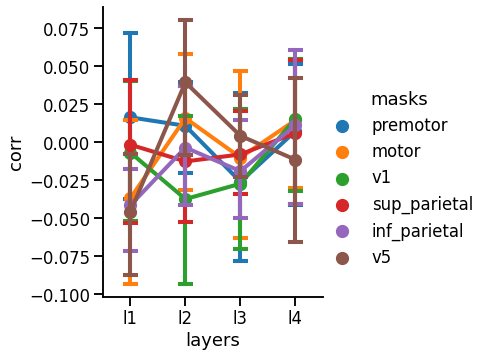

In [30]:
sns.catplot(x = 'layers', y = 'corr', hue = 'masks', data = df_melt, kind = 'point', capsize = 0.2)